In [1]:
import json
import os
import pandas as pd
import isodate
import requests
import numpy as np
import cv2
from collections import Counter
from sklearn.cluster import KMeans
import time
from tqdm import tqdm
import random
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df=pd.read_csv("model_datas.csv", encoding="utf-8-sig")
df

Unnamed: 0  view_count  duration  subscriber_count  brightness  \
0              0    244420.0     459.0          412000.0  109.295617   
1              1     11267.0    1117.0           46500.0  109.632415   
2              2     12158.0    1306.0           15700.0   93.686517   
3              3     14333.0    1772.0           71700.0  139.081451   
4              4     58409.0    1097.0          296000.0  137.706521   
...          ...         ...       ...               ...         ...   
7303        7303     59924.0     890.0           45200.0  169.503289   
7304        7304    348120.0    2072.0          682000.0  104.467790   
7305        7305    857932.0     584.0          552000.0  106.026044   
7306        7306   2799502.0    1351.0          552000.0  127.653263   
7307        7307    176203.0    1275.0            4880.0   66.886318   

       contrast  title_length  word_count  emoji_count  special_char_count  \
0     50.267187            17           9            0                   0   
1     78.918197            98          37            3                   9   
2     89.278624            22          12            0                   1   
3     66.674994            99          50            1                   4   
4     74.693199            55          32            3                   5   
...         ...           ...         ...          ...                 ...   
7303  74.661909            56          21            4                   5   
7304  70.103093            47          20            0                   5   
7305  67.129156            43           9            0                   2   
7306  62.304253            23           9            0                   0   
7307  38.438328            32          15            2                   2   

      ...  person_small  person_medium  person_large  text_left  text_middle  \
0     ...             0              1             1          0            0   
1     ...             0              1             1          0            1   
2     ...             3              5             5          0            0   
3     ...             0              1             1          0            3   
4     ...             0              1             1          3            3   
...   ...           ...            ...           ...        ...          ...   
7303  ...             0              1             1          1            3   
7304  ...             0              2             2          0            0   
7305  ...             0              1             1          0            0   
7306  ...             0              1             1          0            1   
7307  ...             0              1             1          0            0   

      text_right  text_small  text_medium  text_large  cluster  
0              0           0            0           0        7  
1              1           0            2           1        7  
2              0           0            0           0        3  
3              1           2            3           3        0  
4              2           0            5           4        7  
...          ...         ...          ...         ...      ...  
7303           0           1            3           3        3  
7304           0           0            0           0        3  
7305           0           0            0           0        3  
7306           0           0            1           1        3  
7307           0           0            0           0        7  

[7308 rows x 41 columns]

In [25]:
df_cluster=pd.read_csv("updated_cluster.csv", encoding="utf-8-sig")
df_cluster=df_cluster.iloc[:,-1]
df['cluster']=df_cluster

In [9]:
df['log_view_count'] = np.log1p(df['view_count'])

In [11]:
from sklearn.preprocessing import StandardScaler
numeric_cols = ['duration', 'subscriber_count', 'brightness', 'contrast']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [13]:
df['has_question_mark'] = df['has_question_mark'].astype(int)
df['has_exclamation'] = df['has_exclamation'].astype(int)

In [15]:
X = df.drop(columns=['view_count', 'log_view_count'])
y = df['log_view_count']

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

RMSE: 1.55
R-squared: 0.4226


## ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
title_df = pd.read_csv("final_video_data.csv", encoding="utf-8-sig")
title_df

C:\Users\duwjd\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Unnamed: 0                                            title_x  \
0              0                                  Í≤∞Íµ≠ Í∏¥ÌåîÎ¨∏Ïã† Ï†úÍ±∞ ÌïòÎäî Ï°∞ÎëêÌåî   
1              1  [vlog] Í≥†Îì±ÌïôÍµê ÍµêÏÇ¨ ÏßÅÏû•Ïù∏ Î∏åÏù¥Î°úÍ∑∏ | ÌïôÎ∂ÄÎ™® Ï¥ùÌöå Í∑∏Î¶¨Í≥† ÏÉÅÎã¥ Í∞ÄÎìùÌïú Ìïú ...   
2              2                             Ïò§ÏÇ¨Ïπ¥&ÍµêÌÜ† Î∏åÏù¥Î°úÍ∑∏ ‚Ä¢ ÏáºÌïëÏóêÎØ∏Îù§Ïó¨ÏûêÎì§   
3              3  ÎßàÎùºÎ°úÏ†úÏóΩÎñ°+Îã≠Íº¨Ïπò ÍøÄÏ°∞Ìï©‚Ä¢ÎÖ∏Ìã∞Îìú Îî∏Í∏∞Ï†ÑÎ©îÎâ¥üçìÎ®πÍ≥† Í≤∞Íµ≠ ÏªµÎùºÎ©¥2Í∞úÎ°ú ÎßàÎ¨¥Î¶¨‚Ä¢ÏòõÎÇ†ÌÜµÎã≠...   
4              4  [Ïç∞Î†àÎîîÏúóÎØ∏] Ïù¥Ï†† ÎßêÌï† Ïàò ÏûàÎã§üôÑ Ïó≠ÎåÄÍ∏â Îò•Ï∞® Ïç∞ ÎÇãÏó¨Ïò§ÎãàÎùº.„Ö£Ïù¥Í≤å Ïã§ÌôîÎùºÍ≥†? Íµ¨...   
...          ...                                                ...   
7303        7303  (Í¥ëÍ≥†‚ùå) ÏßÄÍ∏à Î∞îÎ°ú Ï†ÅÏö©ÎêòÎäî Ï†ÄÎ†¥Ìïú Ìò∏ÌÖî ÏòàÏïΩ ÍøÄÌåÅ üßëüèª‚Äçüíª Ïù¥Í±¥ Î™∞ÎûêÏùÑÍ±∏..Ï†àÎåÄ...   
7304        7304    12ÏõîÏóê Îòê Í∞à Í≤∞Ïã¨(Ïò®Ï≤úÌò∏ÌÖî, ÌÉÑÍ∏àÌò∏ Ï∫†ÌïëÏû•, Ïª§Ìîº Ï£ºÎäî Î∞ïÎ¨ºÍ¥Ä, ÌïúÎ≥µ ÏÖÄÌîÑÏÇ¨ÏßÑÍ¥Ä)   
7305        7305        ÏùºÎ≥∏ ·Ñè·Ö¢·Ü∏·Ñâ·Ö≤·ÜØ·Ñí·Ö©·Ñê·Ö¶·ÜØ·Ñã·Ö¶·Ñâ·Ö• 50·Ñâ·Öµ·ÑÄ·Ö°·Ü´ ·Ñâ·Ö°·ÜØ·Ñã·Ö°·Ñá·Ö©·ÑÄ·Öµ | ÏùºÎ≥∏#2   
7306        7306                            ÏÑ∏Í≥ÑÏóêÏÑú Í∞ÄÏû• ÏûëÏùÄ ÎÇòÎùºÏùò Í∞ÄÏû• ÏûëÏùÄ Ìò∏ÌÖî   
7307        7307                   Ìï¥Ï¶àÎπà Ìò∏ÌÖî Ïù∏Î¨º ÌÉêÍµ¨ | ÎßåÎä• Ïã∏Ïù¥ÏΩî ÏÇ¨Ïä¥ -üìªÏïåÎûòÏä§ÌÑ∞üìª   

         video_id published_date  \
0     t-zwVkTOZA8     2025-03-28   
1     AMwSEsFVRGg     2025-03-28   
2     PocqBywf0FU     2025-02-24   
3     6eNhJ4LYr1k     2025-03-29   
4     G9tXGudpOCo     2025-03-28   
...           ...            ...   
7303  GPWGgXXT1Aw     2025-01-31   
7304  Q5uzsA3_oTE     2024-11-29   
7305  ZDUE_TI-od8     2024-07-01   
7306  ubnBh-HRcrc     2023-12-25   
7307  WTDMvhnKo9I     2024-07-06   

                                          thumbnail_url  view_count  \
0     https://i.ytimg.com/vi/t-zwVkTOZA8/maxresdefau...    244420.0   
1     https://i.ytimg.com/vi/AMwSEsFVRGg/maxresdefau...     11267.0   
2     https://i.ytimg.com/vi/PocqBywf0FU/maxresdefau...     12158.0   
3     https://i.ytimg.com/vi/6eNhJ4LYr1k/maxresdefau...     14333.0   
4     https://i.ytimg.com/vi/G9tXGudpOCo/maxresdefau...     58409.0   
...                                                 ...         ...   
7303  https://i.ytimg.com/vi/GPWGgXXT1Aw/maxresdefau...     59924.0   
7304  https://i.ytimg.com/vi/Q5uzsA3_oTE/maxresdefau...    348120.0   
7305  https://i.ytimg.com/vi/ZDUE_TI-od8/maxresdefau...    857932.0   
7306  https://i.ytimg.com/vi/ubnBh-HRcrc/maxresdefau...   2799502.0   
7307  https://i.ytimg.com/vi/WTDMvhnKo9I/maxresdefau...    176203.0   

      like_count  comment_count  duration  \
0            NaN          221.0     459.0   
1          265.0           54.0    1117.0   
2          315.0          110.0    1306.0   
3          441.0           71.0    1772.0   
4            NaN          118.0    1097.0   
...          ...            ...       ...   
7303      1928.0           64.0     890.0   
7304     11536.0         1000.0    2072.0   
7305      8408.0          676.0     584.0   
7306     25017.0         1200.0    1351.0   
7307      2659.0          143.0    1275.0   

                                  channel_id  ...  emoji_count  has_emoji  \
0                         ('Ï°∞ÎëêÌåî', '@Ï°∞ÎëêÌåîÏù¥ÎùºÍ≥†')  ...            0          0   
1            ('HappyHojin', '@Happppyhojin')  ...            3          1   
2                      ('Í∂åÏòàÏôïÏôï', '@ye_one_e')  ...            0          0   
3                 ('Ïß∏ÎßÅ', '@buttermellowday')  ...            1          1   
4                   ('ÎÉîÏßÄ nyanji', '@quya_a')  ...            3          1   
...                                      ...  ...          ...        ...   
7303          ('ÏãúÏõîÌïÑÎ¶Ñ October-film', '@ÏãúÏõîÌïÑÎ¶Ñ')  ...            4          1   
7304  ('[ÌïòÎßêÎÑòÎßé] heavytalker', '@heavytalker')  ...            0          0   
7305                     ('ÏÑúÏû¨Î°ú36', '

In [81]:
model = SentenceTransformer("jhgan/ko-sbert-sts")  # HuggingFace Î™®Îç∏
title_embeddings = model.encode(title_df['title_x'].tolist(), show_progress_bar=True)

# Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÏÑ†ÌÉù Î∞è Ï†ïÍ∑úÌôî
meta_features = ['duration','title_length', 'word_count']
X_meta = title_df[meta_features].fillna(0)
X_meta_scaled = StandardScaler().fit_transform(X_meta)

X_combined = np.hstack([X_meta_scaled, title_embeddings])

Batches:   0%|          | 0/229 [00:00<?, ?it/s]

In [12]:
embedding_df = pd.DataFrame({
    'video_id': title_df['video_id'],
    'title': title_df['title_x'],
    'embedding': list(title_embeddings)
})

embedding_df.to_csv("title_embeddings.csv", index=False)

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k(feature_matrix, k_range=range(2, 11), random_state=42):
    wcss = []
    silhouette_scores = []
    db_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(feature_matrix)

        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(feature_matrix, labels))
        db_scores.append(davies_bouldin_score(feature_matrix, labels))

    # üìä ÏãúÍ∞ÅÌôî
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    ax[0].plot(k_range, wcss, marker='o')
    ax[0].set_title('Elbow Method (WCSS)')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('WCSS')

    ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_ylabel('Score')

    ax[2].plot(k_range, db_scores, marker='o', color='red')
    ax[2].set_title('Davies-Bouldin Index')
    ax[2].set_xlabel('Number of Clusters (k)')
    ax[2].set_ylabel('Index (Lower is better)')

    plt.tight_layout()
    plt.show()

    best_silhouette_k = k_range[np.argmax(silhouette_scores)]
    best_db_k = k_range[np.argmin(db_scores)]

    print(f"\n Silhouette Score Í∏∞Ï§Ä ÏµúÏ†Å k: {best_silhouette_k}")
    print(f" Davies-Bouldin Index Í∏∞Ï§Ä ÏµúÏ†Å k: {best_db_k}")

    return {
        "silhouette_best_k": best_silhouette_k,
        "dbi_best_k": best_db_k,
        "wcss": wcss,
        "silhouette_scores": silhouette_scores,
        "db_scores": db_scores
    }


C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

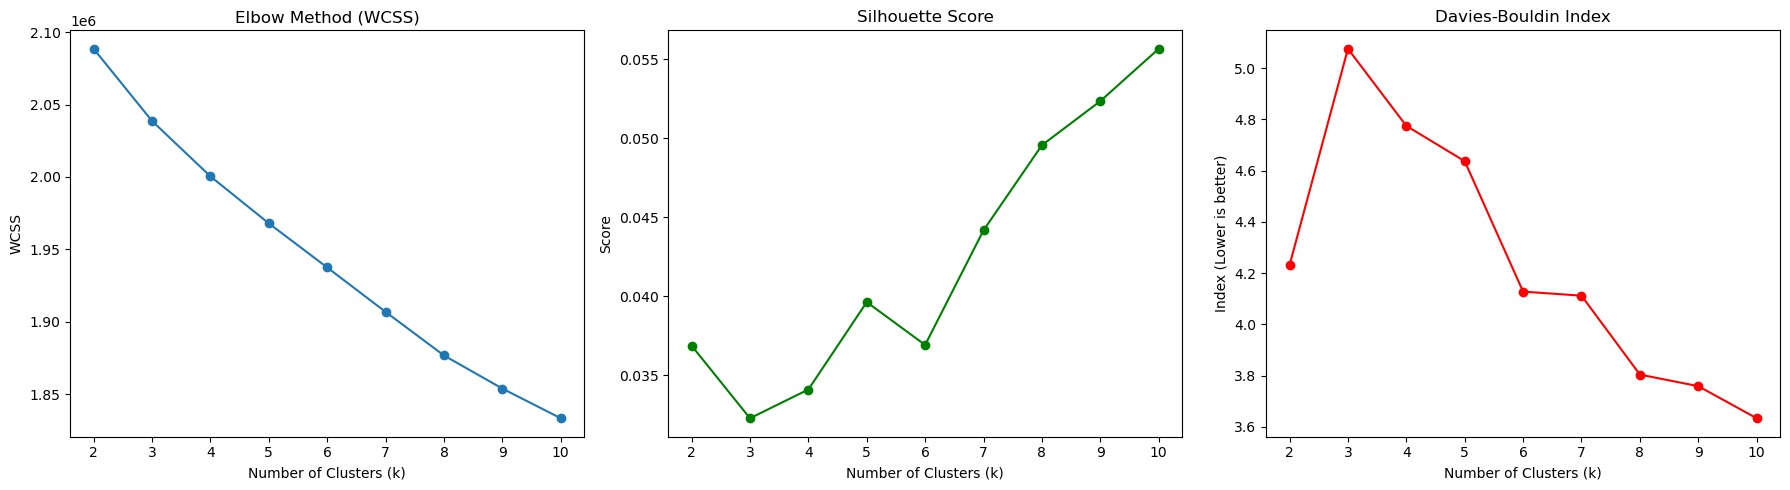


‚úÖ Silhouette Score Í∏∞Ï§Ä ÏµúÏ†Å k: 10
‚úÖ Davies-Bouldin Index Í∏∞Ï§Ä ÏµúÏ†Å k: 10


In [66]:
# title_embeddings + duration, title_length, word_count Ìè¨Ìï®Îêú ÌÜµÌï© ÌîºÏ≤ò
result = find_optimal_k(X_combined, k_range=range(2, 11))

In [82]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
title_df['cluster'] = kmeans.fit_predict(X_combined)

for i in range(n_clusters):
    print(f"\nüîπ ÌÅ¥Îü¨Ïä§ÌÑ∞ {i} ÏòàÏãú Ï†úÎ™©:")
    print(title_df[title_df['cluster'] == i]['title_x'].head(3).to_string(index=False))

print(title_df['cluster'].value_counts().sort_index())

C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



üîπ ÌÅ¥Îü¨Ïä§ÌÑ∞ 0 ÏòàÏãú Ï†úÎ™©:
ÎßàÎùºÎ°úÏ†úÏóΩÎñ°+Îã≠Íº¨Ïπò ÍøÄÏ°∞Ìï©‚Ä¢ÎÖ∏Ìã∞Îìú Îî∏Í∏∞Ï†ÑÎ©îÎâ¥üçìÎ®πÍ≥† Í≤∞Íµ≠ ÏªµÎùºÎ©¥2Í∞úÎ°ú ÎßàÎ¨¥Î¶¨‚Ä¢ÏòõÎÇ†ÌÜµÎã≠ ...
vlog | ÏßëÏàúÏù¥Ïùò Ï£ºÎßê ÏÇºÏãúÏÑ∏ÎÅº ÏßëÎ∞• üõãÔ∏è üí≠  ÎëêÌàºÌïú Ìï®Î∞ïÏä§ÌÖåÏù¥ÌÅ¨Í∞Ä Ïò¨ÎùºÍ∞Ñ Ìà¨ÏõÄ...
                                 ÌïúÍµ≠ ÏôÄÏÑú Ïò§ÏßÄÍ≤å Î®πÎäî Î∏åÏù¥Î°úÍ∑∏

üîπ ÌÅ¥Îü¨Ïä§ÌÑ∞ 1 ÏòàÏãú Ï†úÎ™©:
          ÏïÑÏò§ÎãàÏùò ÌòºÏûê ÏÉà ÎãåÌÖêÎèÑ ÏÇ¨Îü¨Í∞ÄÎäî Î∏åÏù¥Î°úÍ∑∏‚òÖ (feat.ÏÑ∏Î≤àÏß∏ÏÑ¨)
Ïò§ÏßïÏñ¥Í≤åÏûÑ2 3Î∂Ñ ÏöîÏïΩ [Squid Game II 3 Minutes Summary]
               Ïôú ÏïÑÏù¥Ìè∞ÏóêÏÑú Ï†úÏùº Ïû¨Î∞åÎäî Í≤åÏûÑÏù¥ ÎãåÌÖêÎèÑÍ∞Ä ÎêòÏñ¥Î≤ÑÎ†∏ÏùÑÍπå?

üîπ ÌÅ¥Îü¨Ïä§ÌÑ∞ 2 ÏòàÏãú Ï†úÎ™©:
       Í¥ëÍ∏∞ Îã§Ïù¥Ïñ¥ÌÑ∞Ïùò 72ÏãúÍ∞Ñ Î∞ÄÏ∞© Î∏åÏù¥Î°úÍ∑∏ | Ï†ïÏã† Ï∞®Î¶¨Í≥† Îã§Ïù¥Ïñ¥Ìä∏ ÏãúÏûëüèÉ‚Äç‚ôÄÔ∏èüö®
        [Îã§Ïù¥Ïñ¥Ìä∏Î∏åÏù¥Î°úÍ∑∏#2] 3ÏùºÎèôÏïà Í≥ÑÎûÄÏù¥Îûë Îã®Î∞±ÏßàÎ∞îÎßå Î®πÏúºÎ©¥ ÏñºÎßàÎÇò Îπ†ÏßàÍπå?ü•ö
Ï∂úÏÇ∞ÌäπÏßë#6 Î®πÏñ¥Ïïº ÌöåÎ≥µÌïòÏßÄ!! ÏûêÏó∞Î∂ÑÎßå ÏÇ∞Î™® ÌöåÎ≥µ Î∏åÏù¥Î°úÍ∑∏, Ï∂úÏÇ∞ ÏßÅÌõÑ

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
cluster_results = []

# ÌÉÄÍ≤ü Î≥ÄÏàò (Î°úÍ∑∏ Î≥ÄÌôòÌïú Ï°∞ÌöåÏàò)
df['target'] = np.log1p(df['view_count'])  # views Ïª¨ÎüºÎ™ÖÏóê Îî∞Îùº Ï°∞Ï†ï

# ÏÇ¨Ïö©Ìï† feature Ïª¨Îüº ÏßÄÏ†ï (title_length, duration, ÏÉâÏÉÅ, Í∞ùÏ≤¥ Îì± ÏûêÏú†Î°≠Í≤å)
feature_cols = [
    'duration', 'subscriber_count', 'brightness', 'contrast',
       'title_length', 'word_count', 'emoji_count',
       'special_char_count', 'is_clickbait', 'has_question_mark',
       'has_exclamation', 'pub_year', 'pub_month', 'pub_weekday', 'color_red',
       'color_blue', 'color_green', 'color_yellow', 'color_purple',
       'color_brown', 'color_grey', 'color_white', 'color_pink',
       'person_count', 'object_count', 'has_text', 'person_left',
       'person_middle', 'person_right', 'person_small', 'person_medium',
       'person_large', 'text_left', 'text_middle', 'text_right', 'text_small',
       'text_medium', 'text_large'
]

# Íµ∞ÏßëÎ≥ÑÎ°ú Î∞òÎ≥µ
for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id]
    
    if len(cluster_df) < 20:
        print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ {cluster_id} Îç∞Ïù¥ÌÑ∞ ÏàòÍ∞Ä Ï†ÅÏñ¥ Ïä§ÌÇµÎê®: {len(cluster_df)}Í∞ú")
        continue

    X = cluster_df[feature_cols]
    y = cluster_df['target']

    # ÌõàÎ†®/ÌÖåÏä§Ìä∏ Î∂ÑÎ¶¨
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Î™®Îç∏ ÌïôÏäµ
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # ÏòàÏ∏°
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Í≤∞Í≥º Ï†ÄÏû•
    cluster_results.append({
        'cluster': cluster_id,
        'rmse': rmse,
        'r2': r2,
        'sample_size': len(cluster_df)
    })

    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ {cluster_id}: RMSE = {rmse:.4f}, R¬≤ = {r2:.4f}")


ÌÅ¥Îü¨Ïä§ÌÑ∞ 0: RMSE = 1.1829, R¬≤ = 0.6026
ÌÅ¥Îü¨Ïä§ÌÑ∞ 1: RMSE = 1.0515, R¬≤ = 0.5166
ÌÅ¥Îü¨Ïä§ÌÑ∞ 2: RMSE = 1.1980, R¬≤ = 0.6830
ÌÅ¥Îü¨Ïä§ÌÑ∞ 3: RMSE = 1.6990, R¬≤ = 0.3217
ÌÅ¥Îü¨Ïä§ÌÑ∞ 4: RMSE = 1.0337, R¬≤ = 0.5816
ÌÅ¥Îü¨Ïä§ÌÑ∞ 5: RMSE = 1.1968, R¬≤ = 0.3005
ÌÅ¥Îü¨Ïä§ÌÑ∞ 6: RMSE = 1.7755, R¬≤ = 0.2649
ÌÅ¥Îü¨Ïä§ÌÑ∞ 7: RMSE = 1.6063, R¬≤ = 0.4719
ÌÅ¥Îü¨Ïä§ÌÑ∞ 8: RMSE = 1.1273, R¬≤ = 0.5080
ÌÅ¥Îü¨Ïä§ÌÑ∞ 9: RMSE = 1.9965, R¬≤ = 0.0978


In [155]:
### ÌÅ¥Îü¨Ïä§ÌÑ∞ quantile ÎÇòÎà†ÏÑú Îã§Ïãú Ìï¥Î≥¥Í∏∞
cluster_9_df = df[df['cluster'] == 9]
q98 = cluster_9_df['view_count'].quantile(0.98)
trimmed_df = cluster_9_df[cluster_9_df['view_count'] <= q98].copy()

# ÌÉÄÍπÉ: Î°úÍ∑∏ Î≥ÄÌôòÎêú Ï°∞ÌöåÏàò
trimmed_df['target'] = np.log1p(trimmed_df['view_count'])

X = trimmed_df[feature_cols]
y = trimmed_df['target']

# ÌïôÏäµ/ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Î™®Îç∏ ÌïôÏäµ
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# ÏòàÏ∏° Î∞è ÏÑ±Îä• ÌèâÍ∞Ä
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}, R¬≤: {r2:.4f}")

RMSE: 1.8615, R¬≤: 0.2066


### Ïû¨ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ (RÏä§ÌÄòÏñ¥Í∞í ÎÇÆÏùÄ 5,6,9Îßå)

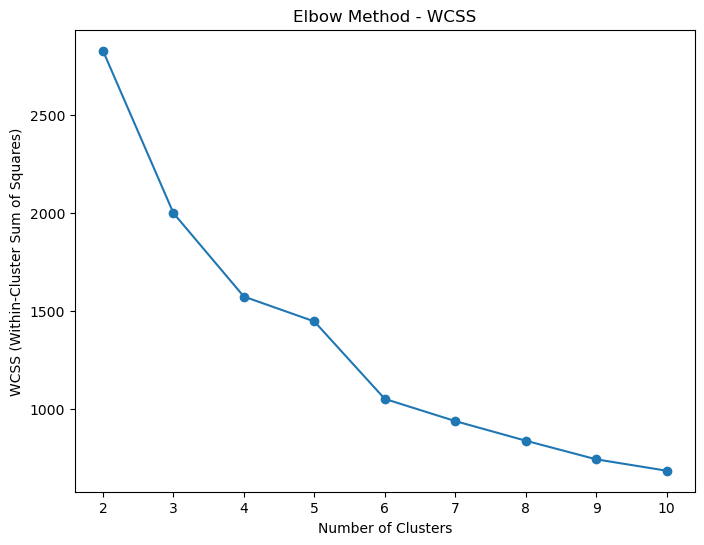

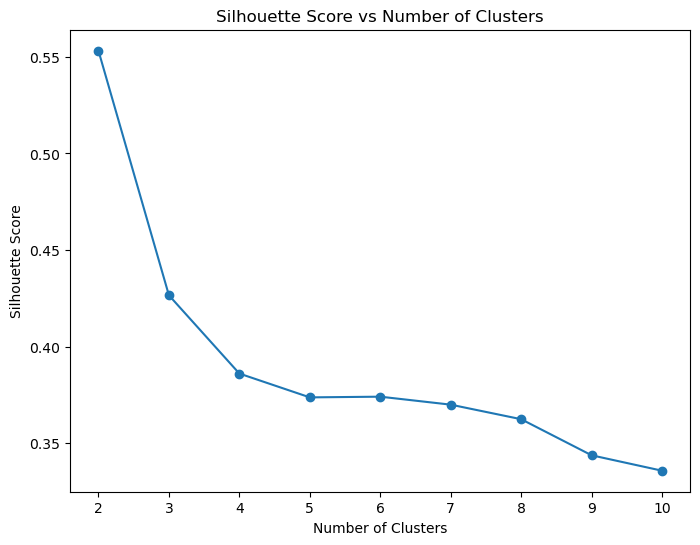

Optimal number of clusters (based on silhouette score): 2


In [137]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. ÌååÏùº Î°úÎìú
df = title_df
embeddings_df = pd.read_csv("title_embeddings.csv")  # title_embeddings Ï†ÄÏû•Îêú csv

# 2. ÌïÑÏöîÌïú Ïª¨Îüº ÌôïÏù∏
meta_features = ['duration', 'title_length', 'word_count']
assert all(col in df.columns for col in meta_features + ['cluster'])

# 3. ÌÉÄÍ≤ü ÌÅ¥Îü¨Ïä§ÌÑ∞Îßå ÏÑ†ÌÉù
target_clusters = [8,9,10]
sub_df = df[df['cluster'].isin(target_clusters)].copy()

# 4. ÏûÑÎ≤†Îî© Ïó∞Í≤∞ (video_id Îì±ÏúºÎ°ú merge)
sub_df = sub_df.merge(embeddings_df, on='video_id', how='left')

# 5. ÏûÑÎ≤†Îî© Ïª¨Îüº Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
embedding_cols = [col for col in embeddings_df.columns if col.startswith('embed_')]
embedding_matrix = sub_df[embedding_cols].values

# 6. Î©îÌÉÄ Ï†ïÍ∑úÌôî
from sklearn.preprocessing import StandardScaler
meta_scaled = StandardScaler().fit_transform(sub_df[meta_features].fillna(0))

# 7. Î≤°ÌÑ∞ Í≤∞Ìï©
X_combined = np.hstack([meta_scaled, embedding_matrix])

# 8. ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò Ï∞æÍ∏∞ (Elbow MethodÏôÄ Silhouette Score ÏÇ¨Ïö©)

# Elbow Method (WCSS)
wcss = []
silhouette_scores = []
max_clusters = 10  # ÏµúÎåÄÎ°ú ÏãúÎèÑÌï† ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò

for n_clusters in range(2, max_clusters + 1):  # 2Î∂ÄÌÑ∞ max_clustersÍπåÏßÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò Î≥ÄÌôî
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    kmeans.fit(X_combined)
    
    # WCSS Í≥ÑÏÇ∞ (Elbow MethodÏö©)
    wcss.append(kmeans.inertia_)
    
    # Silhouette Score Í≥ÑÏÇ∞
    score = silhouette_score(X_combined, kmeans.labels_)
    silhouette_scores.append(score)

# Elbow Method Í∑∏ÎûòÌîÑ
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method - WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Silhouette Score Í∑∏ÎûòÌîÑ
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò ÏÑ†ÌÉù (Silhouette Score Í∏∞Ï§Ä)
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # ÏµúÎåÄÍ∞íÏóê Ìï¥ÎãπÌïòÎäî ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò
print(f"Optimal number of clusters (based on silhouette score): {optimal_clusters}")

# 9. KMeans ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ (ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò ÏÇ¨Ïö©)
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init="auto")
sub_df['recluster'] = kmeans.fit_predict(X_combined)

DBSCAN Silhouette Score: 0.33377634570469844


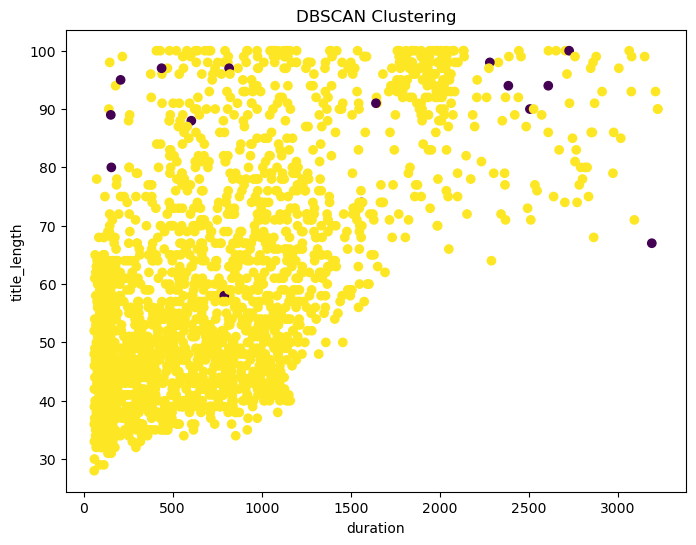

Agglomerative Clustering Silhouette Score: 0.36705815259975544


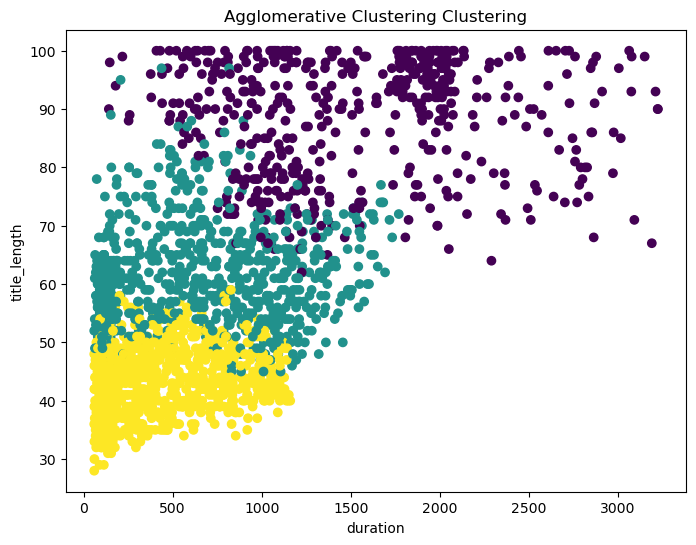

Gaussian Mixture Model Silhouette Score: 0.22667807669581833


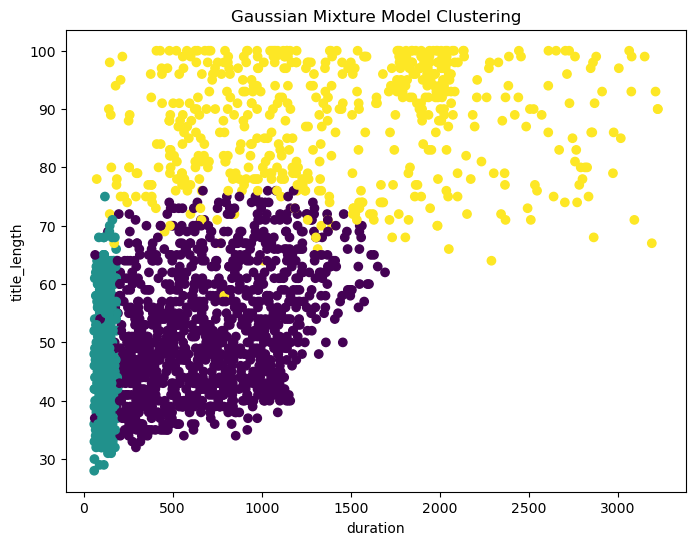

      video_id  recluster
0  DePBBfhQfGE          0
1  vtQ0KhiEP9U          2
2  4p497_IPaSU          0
3  kuFVtsAkgzI          2
4  SuWGN3kvVfo          2


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. ÌååÏùº Î°úÎìú
df = title_df
embeddings_df = pd.read_csv("title_embeddings.csv")  # title_embeddings Ï†ÄÏû•Îêú csv

# 2. ÌïÑÏöîÌïú Ïª¨Îüº ÌôïÏù∏
meta_features = ['duration', 'title_length', 'word_count']
assert all(col in df.columns for col in meta_features + ['cluster'])

# 3. ÌÉÄÍ≤ü ÌÅ¥Îü¨Ïä§ÌÑ∞Îßå ÏÑ†ÌÉù
target_clusters = [8,9]
sub_df = df[df['cluster'].isin(target_clusters)].copy()

# 4. ÏûÑÎ≤†Îî© Ïó∞Í≤∞ (video_id Îì±ÏúºÎ°ú merge)
sub_df = sub_df.merge(embeddings_df, on='video_id', how='left')

# 5. ÏûÑÎ≤†Îî© Ïª¨Îüº Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
embedding_cols = [col for col in embeddings_df.columns if col.startswith('embed_')]
embedding_matrix = sub_df[embedding_cols].values

# 6. Î©îÌÉÄ Ï†ïÍ∑úÌôî
meta_scaled = StandardScaler().fit_transform(sub_df[meta_features].fillna(0))

# 7. Î≤°ÌÑ∞ Í≤∞Ìï©
X_combined = np.hstack([meta_scaled, embedding_matrix])

# ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÏïåÍ≥†Î¶¨Ï¶ò Î¶¨Ïä§Ìä∏
clustering_algorithms = {
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=3),
    'Gaussian Mixture Model': GaussianMixture(n_components=3, random_state=42)
}

# 8. ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÏïåÍ≥†Î¶¨Ï¶ò ÏàòÌñâ Î∞è ÏÑ±Îä• ÌèâÍ∞Ä
for name, algorithm in clustering_algorithms.items():
    sub_df['recluster'] = algorithm.fit_predict(X_combined)
    
    # Silhouette Score Í≥ÑÏÇ∞
    if len(set(sub_df['recluster'])) > 1:  # Íµ∞ÏßëÏù¥ 1Í∞úÏùº Í≤ΩÏö∞Îäî Silhouette Score Í≥ÑÏÇ∞ ÏïàÌï®
        score = silhouette_score(X_combined, sub_df['recluster'])
        print(f"{name} Silhouette Score: {score}")
    else:
        print(f"{name} - No valid clusters formed.")
    
    # Í≤∞Í≥º ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(8, 6))
    plt.scatter(sub_df[meta_features[0]], sub_df[meta_features[1]], c=sub_df['recluster'], cmap='viridis')
    plt.title(f'{name} Clustering')
    plt.xlabel(meta_features[0])
    plt.ylabel(meta_features[1])
    plt.show()

# Í≤∞Í≥º ÌôïÏù∏
print(sub_df[['video_id', 'recluster']].head())

In [139]:
print(sub_df['recluster'].value_counts().sort_index())

0     691
1    1727
Name: recluster, dtype: int64


In [141]:
# 9. Í∏∞Ï°¥ dfÏóê Î∞òÏòÅ
for i in range(len(sub_df)):
    df.iloc[sub_df.iloc[i,0], 30] = sub_df.iloc[i,34] + 100  # Ïòà: ÏÉà cluster 100~102Î°ú Ìï†Îãπ
print(df['cluster'].value_counts().sort_index())

0       697
1       225
2       264
3       452
4      1678
5       219
6       766
7       589
100     691
101    1727
Name: cluster, dtype: int64


In [143]:
cluster_mapping = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    100: 8,
    101: 9
}

# 'cluster' ÏπºÎüºÏóêÏÑú Í∏∞Ï°¥ Í∞íÏùÑ ÏÉàÎ°úÏö¥ Í∞íÏúºÎ°ú Î≥ÄÌôò
df['cluster'] = df['cluster'].replace(cluster_mapping)

In [145]:
df_1=pd.read_csv("model_datas.csv", encoding="utf-8-sig")
df_1['cluster']=df['cluster']
df=df_1
df

Unnamed: 0  view_count  duration  subscriber_count  brightness  \
0              0    244420.0     459.0          412000.0  109.295617   
1              1     11267.0    1117.0           46500.0  109.632415   
2              2     12158.0    1306.0           15700.0   93.686517   
3              3     14333.0    1772.0           71700.0  139.081451   
4              4     58409.0    1097.0          296000.0  137.706521   
...          ...         ...       ...               ...         ...   
7303        7303     59924.0     890.0           45200.0  169.503289   
7304        7304    348120.0    2072.0          682000.0  104.467790   
7305        7305    857932.0     584.0          552000.0  106.026044   
7306        7306   2799502.0    1351.0          552000.0  127.653263   
7307        7307    176203.0    1275.0            4880.0   66.886318   

       contrast  title_length  word_count  emoji_count  special_char_count  \
0     50.267187            17           9            0                   0   
1     78.918197            98          37            3                   9   
2     89.278624            22          12            0                   1   
3     66.674994            99          50            1                   4   
4     74.693199            55          32            3                   5   
...         ...           ...         ...          ...                 ...   
7303  74.661909            56          21            4                   5   
7304  70.103093            47          20            0                   5   
7305  67.129156            43           9            0                   2   
7306  62.304253            23           9            0                   0   
7307  38.438328            32          15            2                   2   

      ...  person_small  person_medium  person_large  text_left  text_middle  \
0     ...             0              1             1          0            0   
1     ...             0              1             1          0            1   
2     ...             3              5             5          0            0   
3     ...             0              1             1          0            3   
4     ...             0              1             1          3            3   
...   ...           ...            ...           ...        ...          ...   
7303  ...             0              1             1          1            3   
7304  ...             0              2             2          0            0   
7305  ...             0              1             1          0            0   
7306  ...             0              1             1          0            1   
7307  ...             0              1             1          0            0   

      text_right  text_small  text_medium  text_large  cluster  
0              0           0            0           0        4  
1              1           0            2           1        4  
2              0           0            0           0        6  
3              1           2            3           3        0  
4              2           0            5           4        4  
...          ...         ...          ...         ...      ...  
7303           0           1            3           3        9  
7304           0           0            0           0        7  
7305           0           0            0           0        6  
7306           0           0            1           1        6  
7307           0           0            0           0        4  

[7308 rows x 41 columns]

In [148]:
df.to_csv('model_datas.csv', encoding='utf-8-sig')

In [147]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm

# Î°úÍ∑∏ Î≥ÄÌôòÎêú ÌÉÄÍ≤ü ÏÉùÏÑ±
df['target'] = np.log1p(df['view_count'])

# ÏÇ¨Ïö©Ìï† ÌöåÍ∑Ä Î™®Îç∏Îì§ Ï†ïÏùò
model_list = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42,
    min_data_in_leaf=5,         
    min_gain_to_split=0.0,       
    n_estimators=100,
    learning_rate=0.05),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
cluster_model_results = []

# Íµ∞ÏßëÎ≥Ñ Î∞òÎ≥µ
for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id].copy()

    if len(cluster_df) < 20:
        print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ {cluster_id}ÏùÄ ÏÉòÌîå Î∂ÄÏ°± ‚Üí Ïä§ÌÇµÎê® ({len(cluster_df)}Í∞ú)")
        continue

    X = cluster_df[feature_cols]
    y = cluster_df['target']

    # ÌõàÎ†®/ÌÖåÏä§Ìä∏ Î∂ÑÎ¶¨
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    best_model_name = None
    best_model_score = -np.inf
    best_rmse = None

    for name, model in model_list.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            if r2 > best_model_score:
                best_model_name = name
                best_model_score = r2
                best_rmse = rmse

        except Exception as e:
            print(f"[{name}] Î™®Îç∏ Ïò§Î•ò in ÌÅ¥Îü¨Ïä§ÌÑ∞ {cluster_id}: {e}")
            continue

    cluster_model_results.append({
        "cluster": cluster_id,
        "best_model": best_model_name,
        "rmse": round(best_rmse, 4),
        "r2": round(best_model_score, 4),
        "sample_size": len(cluster_df)
    })

results_df = pd.DataFrame(cluster_model_results).sort_values(by="r2", ascending=False)
print(results_df)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 38
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, 

## Î™®Îç∏ÌïôÏäµ

In [ ]:
import optuna
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Ïóê ÎåÄÌï¥ ÏµúÏ†Å Î™®Îç∏ ÏßÄÏ†ï
cluster_best_models = {
    0: "LightGBM",
    1: "GradientBoosting",
    2: "RandomForest",
    3: "LightGBM",
    4: "LightGBM",
    5: "RandomForest",
    6: "RandomForest",
    7: "XGBoost",
    8: "LightGBM",
    9: "RandomForest"
}

# Î™®Îç∏ Ï†ÄÏû•Ïö© ÎîïÏÖîÎÑàÎ¶¨
trained_models = []
optuna_results = []

# ÌîºÏ≤ò Ïª¨Îüº
feature_cols = [
    'duration', 'subscriber_count', 'brightness', 'contrast',
    'title_length', 'word_count', 'emoji_count', 
    'special_char_count', 'is_clickbait', 'has_question_mark',
    'has_exclamation', 'pub_year', 'pub_month', 'pub_weekday', 'color_red',
    'color_blue', 'color_green', 'color_yellow', 'color_purple',
    'color_brown', 'color_grey', 'color_white', 'color_pink',
    'person_count', 'object_count', 'has_text', 'person_left',
    'person_middle', 'person_right', 'person_small', 'person_medium',
    'person_large', 'text_left', 'text_middle', 'text_right', 'text_small',
    'text_medium', 'text_large'
]

# Í∞Å Î™®Îç∏Ïóê ÎåÄÌïú ÏµúÏ†ÅÌôî Ìï®Ïàò Ï†ïÏùò
def objective_rf(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, step=2)

    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

def objective_gb(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, step=2)

    gb = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                   learning_rate=learning_rate, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

def objective_lgb(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50, step=5)

    lgb = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                        min_child_samples=min_child_samples, random_state=42)
    lgb.fit(X_train, y_train)
    y_pred = lgb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# Î™®Îç∏ ÌïôÏäµ Î∞è ÏµúÏ†ÅÌôî
for cluster_id, model_name in tqdm(cluster_best_models.items()):
    # Ìï¥Îãπ ÌÅ¥Îü¨Ïä§ÌÑ∞ Îç∞Ïù¥ÌÑ∞ ÏÑ†ÌÉù
    cluster_df = df[df['cluster'] == cluster_id].copy()
    X = cluster_df[feature_cols]
    y = np.log1p(cluster_df['view_count'])  # ÌÉÄÍ≤ü: log(1+view_count)

    # ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏôÄ Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Î°ú Î∂ÑÎ¶¨
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Optuna ÏµúÏ†ÅÌôî Ìï®Ïàò ÏÑ†ÌÉù
    def opt_objective(trial):
        if model_name == "RandomForest":
            return objective_rf(trial, X_train, y_train, X_val, y_val)
        elif model_name == "GradientBoosting":
            return objective_gb(trial, X_train, y_train, X_val, y_val)
        elif model_name == "LightGBM":
            return objective_lgb(trial, X_train, y_train, X_val, y_val)

    # Optuna ÏµúÏ†ÅÌôî
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_objective, n_trials=20)

    # ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
    best_params = study.best_params

    # ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞Î°ú Î™®Îç∏ Ïû¨ÌïôÏäµ
    if model_name == "RandomForest":
        model = RandomForestRegressor(**best_params, random_state=42)
    elif model_name == "GradientBoosting":
        model = GradientBoostingRegressor(**best_params, random_state=42)
    elif model_name == "LightGBM":
        model = LGBMRegressor(**best_params, random_state=42)

    model.fit(X_train, y_train)
    trained_models.append(model)

    # ÏòàÏ∏° Î∞è ÏÑ±Îä• ÌèâÍ∞Ä
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    optuna_results.append({
        "cluster": cluster_id,
        "model": model_name,
        "rmse": round(rmse, 4),
        "r2": round(r2, 4),
        "best_params": best_params
    })

# Í≤∞Í≥º ÌôïÏù∏
result_df = pd.DataFrame(optuna_results).sort_values(by="r2", ascending=False)
print(result_df)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s][I 2025-05-01 11:17:09,166] A new study created in memory with name: no-name-b8f68508-c780-476b-93db-174f29263051


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:10,245] Trial 0 finished with value: 1.2444763871433537 and parameters: {'n_estimators': 600, 'max_depth': 14, 'learning_rate': 0.003851100574972928, 'min_child_samples': 15}. Best is trial 0 with value: 1.2444763871433537.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-01 11:17:10,701] Trial 1 finished with value: 1.2164263255885104 and parameters: {'n_estimators': 600, 'max_depth': 11, 'learning_rate': 0.017405127078500348, 'min_child_samples': 50}. Best is trial 1 with value: 1.2164263255885104.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:11,019] Trial 2 finished with value: 1.2190768627497799 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.09560629743844412, 'min_child_samples': 40}. Best is trial 1 with value: 1.2164263255885104.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:11,473] Trial 3 finished with value: 1.1940212319296757 and parameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.008733650551510005, 'min_child_samples': 25}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:11,983] Trial 4 finished with value: 1.1940331694040078 and parameters: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.02162727144983112, 'min_child_samples': 15}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 34
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:12,792] Trial 5 finished with value: 1.2792829240698258 and parameters: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.0017457949806030813, 'min_child_samples': 30}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:13,758] Trial 6 finished with value: 1.2035678017864475 and parameters: {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.006743284270631512, 'min_child_samples': 20}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-01 11:17:14,577] Trial 7 finished with value: 1.3473314224794388 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.0010303677742608762, 'min_child_samples': 40}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:14,685] Trial 8 finished with value: 1.5738883432455222 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.0037318068437701534, 'min_child_samples': 40}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:15,332] Trial 9 finished with value: 1.237897249639394 and parameters: {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.033563163786193895, 'min_child_samples': 50}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:15,564] Trial 10 finished with value: 1.2050539004278222 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.058088296010573165, 'min_child_samples': 5}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 38
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-01 11:17:15,996] Trial 11 finished with value: 1.1929624900641067 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.015411530825772521, 'min_child_samples': 20}. Best is trial 11 with value: 1.1929624900641067.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:16,298] Trial 12 finished with value: 1.2122673730173086 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.009338724787199172, 'min_child_samples': 25}. Best is trial 11 with value: 1.1929624900641067.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:16,578] Trial 13 finished with value: 1.2224416604199044 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01383737444119881, 'min_child_samples': 30}. Best is trial 11 with value: 1.1929624900641067.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 34
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:17,984] Trial 14 finished with value: 1.1729856340532834 and parameters: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.006369316778028757, 'min_child_samples': 5}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 38
[LightGBM] [Info] Start training from score 12.431337


[I 2025-05-01 11:17:18,909] Trial 15 finished with value: 1.221051850331323 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.004385945293238668, 'min_child_samples': 5}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 37
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:20,096] Trial 16 finished with value: 1.2143661288572343 and parameters: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.029373506734802664, 'min_child_samples': 10}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:21,518] Trial 17 finished with value: 1.2569736184743279 and parameters: {'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.002498971122161598, 'min_child_samples': 15}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 37
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:22,307] Trial 18 finished with value: 1.226187678244277 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.0053926990343582835, 'min_child_samples': 10}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:22,872] Trial 19 finished with value: 1.173365962217632 and parameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.014644394364073759, 'min_child_samples': 20}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 38
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                          | 1/10 [00:15<02:15, 15.04s/it][I 2025-05-01 11:17:24,208] A new study created in memory with name: no-name-f115b970-aa76-4073-a0b3-f024333737ba
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-01 11:17:25,195] Trial 0 finished with value: 1.4357887586238025 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.0012063633016535847, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 0 with value: 1.4357887586238025.
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-01 11:17:27,

In [45]:
import joblib
import os

# Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï (web Ìè¥Îçî ÎÇ¥ Ï†ÄÏû•)
save_dir = r"C:\web\saved_models"  # Ïõπ Í≤ΩÎ°úÎ°ú Ï†ÄÏû•

# ÎîîÎ†âÌÜ†Î¶¨Í∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏúºÎ©¥ ÏÉùÏÑ±
os.makedirs(save_dir, exist_ok=True)

# ÌÅ¥Îü¨Ïä§ÌÑ∞ Î≤àÌò∏ÏôÄ Î™®Îç∏ Í∞ùÏ≤¥Í∞Ä Ï†ÄÏû•Îêú trained_models ÎîïÏÖîÎÑàÎ¶¨ (ÏòàÏãú)
# trained_models = {ÌÅ¥Îü¨Ïä§ÌÑ∞ Î≤àÌò∏: Î™®Îç∏ Í∞ùÏ≤¥}
# trained_models = {...}

# Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Î™®Îç∏ Ï†ÄÏû•
for cluster_id, model in trained_models.items():
    # Ï†ÄÏû• Í≤ΩÎ°ú ÏßÄÏ†ï (web Ìè¥Îçî ÎÇ¥ Ï†ÄÏû•)
    path = os.path.join(save_dir, f"model_cluster_{cluster_id}.pkl")
    
    # Î™®Îç∏ Ï†ÄÏû•
    joblib.dump(model, path)
    
    # Ï†ÄÏû• ÏôÑÎ£å Ï∂úÎ†•
    print(f"ÌÅ¥Îü¨Ïä§ÌÑ∞ {cluster_id} Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí {path}")


‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 0 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_0.pkl
‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 1 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_1.pkl
‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 2 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_2.pkl
‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 3 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_3.pkl
‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 4 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_4.pkl
‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 5 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_5.pkl
‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 6 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_6.pkl
‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 7 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_7.pkl
‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ 8 Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å ‚Üí saved_models/model_cluster_8.pkl


### ÏûÑÎ≤†Îî© ÌååÏùº Î∂àÎü¨ÏôÄÏÑú Ï†ÑÏ≤¥ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ

C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from c

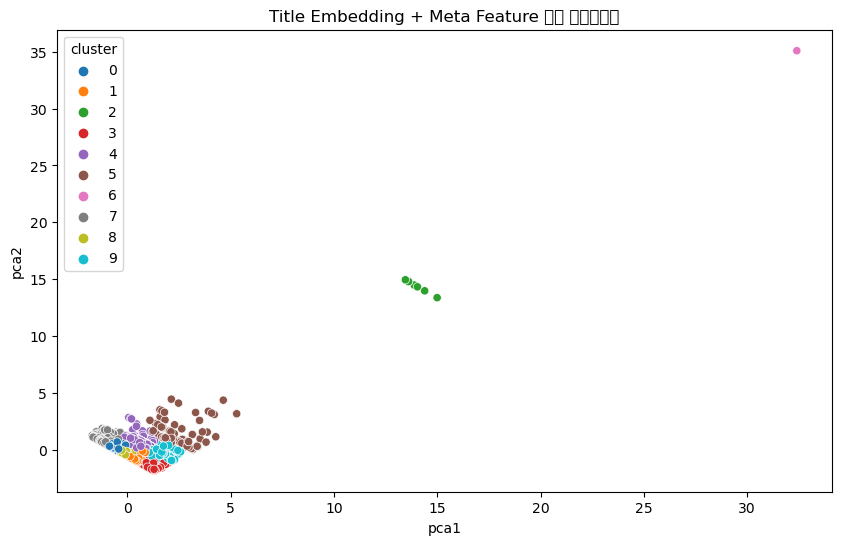

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# üîπ 1. title_embedding.csv Î°úÎìú
embedding_df = pd.read_csv("title_embeddings.csv")

# üîπ 2. Ï†ÑÏ≤¥ ÌîºÏ≤òÍ∞Ä Ìè¨Ìï®Îêú Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ df (Ïù¥ÎØ∏ ÏûàÎã§Í≥† Í∞ÄÏ†ï)
# Ïòà: df = pd.read_csv("full_data.csv")
# dfÏóêÎäî video_id, subscriber_count, title_lengthÍ∞Ä Ìè¨Ìï®Îèº ÏûàÏñ¥Ïïº Ìï®

# üîπ 3. Î≥ëÌï©
merged_df = pd.merge(embedding_df, title_df[['video_id', 'subscriber_count', 'title_length']], on='video_id', how='inner')

# üîπ 4. ÌîºÏ≤ò Ï∂îÏ∂ú
embedding_cols = [col for col in merged_df.columns if col.startswith("emb_")]
X_embedding = merged_df[embedding_cols].values
X_meta = merged_df[['subscriber_count', 'title_length']].fillna(0).values

# üîπ 5. Ï†ïÍ∑úÌôî + Í≤∞Ìï©
X_combined = np.hstack([X_meta, X_embedding])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# üîπ 6. KMeans ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
k = 10  # Íµ∞Ïßë Ïàò
kmeans = KMeans(n_clusters=k, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(X_scaled)

# üîπ 7. ÏãúÍ∞ÅÌôî (PCA 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged_df['pca1'] = X_pca[:, 0]
merged_df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("Title Embedding + Meta Feature Í∏∞Î∞ò ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ")
plt.show()

# üîπ 8. Ï†ÄÏû•
#merged_df.to_csv("merged_clustered_result.csv", index=False)
